# Resnet33 for Real Time Automatic Modulation Classification

### Import Statements

In [1]:
import os
import torch
import h5py
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os
import numpy as np
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from pathlib import Path
from torchsummary import summary
import brevitas.nn as qnn
from brevitas.core.quant import QuantType

### Define Module

In [2]:
# Quantized ResNet

quant_type = QuantType.INT
prec = 8

class resnet33_quant(torch.nn.Module):
    def __init__(self, channels):
        super(resnet33_quant, self).__init__() #Consider only 1 residual stack layer
        self.conv1 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv3 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv4 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv5 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        
        self.conv6 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv7 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv8 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv9 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        
        self.conv10 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv11 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv12 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv13 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        
        self.conv14 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv15 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv16 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        self.conv17 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        
        self.conv18 = torch.nn.Sequential(qnn.QuantConv1d(in_channels=channels*32, out_channels=channels*32, kernel_size=3, padding=1, weight_quant_type=quant_type, weight_bit_width=prec),torch.nn.BatchNorm1d(channels*32))
        
        self.classifier = torch.nn.Sequential(qnn.QuantLinear(channels*512, 128, bias=True, weight_quant_type=quant_type, weight_bit_width=prec),
                                        #torch.nn.SELU(True),
                                        qnn.QuantReLU(quant_type=QuantType.INT, bit_width=prec, max_val=6),
                                        #torch.nn.Dropout(),
                                        qnn.QuantLinear(128, 128, bias=True, weight_quant_type=quant_type, weight_bit_width=prec),
                                        #torch.nn.SELU(True),
                                        qnn.QuantReLU(quant_type=QuantType.INT, bit_width=prec, max_val=6),
                                        #torch.nn.Dropout(), 
                                        qnn.QuantLinear(128, 24, bias=True, weight_quant_type=quant_type, weight_bit_width=prec))
                                        #torch.nn.Softmax(dim=1)) 
            
    def forward(self,x):
        #Residual Stack 1
        y1 = F.relu(self.conv1(x)) #1'st layer con
        y2 = F.relu(self.conv2(y1))
        y3 = self.maxpool(F.relu(self.conv3(y2) + y1))
        
        #Residual Stack 2
        y4 = self.conv4(y3)
        y5 = F.relu(self.conv5(y4))
        y6 = self.maxpool(F.relu(self.conv6(y5) + y4))
        
        #Residual Stack 3
        y4 = self.conv7(y6)
        y5 = F.relu(self.conv8(y4))
        y6 = self.maxpool(F.relu(self.conv9(y5) + y4))
        
        #Residual Stack 4
        y4 = self.conv10(y6)
        y5 = F.relu(self.conv11(y4))
        y6 = self.maxpool(F.relu(self.conv12(y5) + y4))
        
        #Residual Stack 5
        y4 = self.conv13(y6)
        y5 = F.relu(self.conv14(y4))
        y6 = self.maxpool(F.relu(self.conv15(y5) + y4))
        
        #Residual Stack 6
        y4 = self.conv16(y6)
        y5 = F.relu(self.conv17(y4))
        y6 = self.maxpool(F.relu(self.conv18(y5) + y4))
        
        y7 = torch.flatten(y6,1)
        y8 = self.classifier(y7)
        
        return y8

In [3]:
class H5Dataset(data.Dataset):

    def __init__(self, file_path):
        super(H5Dataset, self).__init__()
        h5_file = h5py.File(file_path,'r')
        self.X = h5_file['X']
        self.Y = h5_file['Y']
        self.Z = h5_file['Z']

    def __getitem__(self, index):
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #print(index)
        Y = torch.from_numpy(self.Y[index])
        return torch.from_numpy(self.X[index]).float(),torch.argmax(Y),torch.from_numpy(self.Z[index]).float()
        #return self.data

    def __len__(self):
        return self.X.shape[0]

### Train Network

In [4]:
import matplotlib.pyplot as plt
import time

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 9:
        lr = 1e-4
    elif epoch > 2:
        lr = 1e-3
    else:
        lr = 1e-2
    print('Learning rate: ', lr)
    return lr

train_losses = []
accuracies = []
times = []

def train_model(net, train_loader, epochs, criterion, device):
    net.train()
    running_loss = 0.0
    steps = 0
    epoch_start = 0
    correct = 0

    time_start = time.time()
    for epoch in range(epoch_start,epoch_start+epochs):
        optimizer = optim.SGD(net.parameters(), lr=lr_schedule(epoch), momentum=0.9, weight_decay=1e-4)
        for i, data in tqdm(enumerate(train_loader)):
            steps += 1
            signals, labels, snr = data
            signals, labels = signals.to(device), labels.to(device)
            #print(labels)
            signals_mean = torch.mean(signals, 1, keepdims=True)
            #print(signals.size())
            #print(signals_mean.size())
            signals = signals - signals_mean
            signals = torch.transpose(signals, 1, 2)
            
            optimizer.zero_grad()
            outputs = net.forward(signals)
            correct += torch.sum((torch.argmax(outputs,dim=1) == labels)).item()
            #print(torch.argmax(outputs,dim=1)==labels, correct)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        train_loss = running_loss/len(train_loader)
        accuracy = correct/(48*len(train_loader))
        
        train_losses.append(train_loss)
        accuracies.append(accuracy)
        times.append(time.time() - time_start)
        
        print(f"Epoch {epoch+1}/{epoch_start+epochs}.. "
                          f"Train loss: {train_loss:.3f}.. ")
        print('Accuracy {:f}'.format(accuracy))
        running_loss = 0
        correct = 0
        print("Steps completed: ",steps)
                
        PATH = './resnet33_radioml_brevitas_epoch_{:d}.pth'.format(epoch)
        torch.save(net.state_dict(), PATH)

In [5]:
input_data = H5Dataset("/dataset/201801/GOLD_XYZ_OSC.0001_1024.hdf5")
dataset_size = len(input_data)
print(dataset_size)

indices = []
for i in range (0, 24):
    temp = list(range(106496*i +4096*13, 106496*i + 4096*26)) #Get only SNR > 6dB
    indices.extend(temp)
print(len(indices))

split = int(np.floor(0.2*len(indices)))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

#print(train_indices.shape)
#print(val_indices.shape)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
validation_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(input_data, batch_size=48, shuffle=False, sampler=train_sampler, num_workers=48, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(input_data, batch_size=48, shuffle=False, sampler=validation_sampler, num_workers=48, pin_memory=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# setting up for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# if starting
net = resnet33_quant(2)
net = net.to(device)
# else
#PATH = './resnet33_radioml_brevitas_epoch_9.pth'
#net = resnet33_quant(2)
#net.to(device)
#net.load_state_dict(torch.load(PATH))

#summary(net, input_size=(2, 1024))
print(sum([param.nelement() for param in net.parameters()]))

criterion = nn.CrossEntropyLoss()
epochs = 10

train_model(net, train_loader, epochs, criterion, device)

2555904
1277952
cuda:0


/opt/conda/lib/python3.7/site-packages/torch/jit/_recursive.py:145: UserWarning: 'stats_reduce_dim' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
/opt/conda/lib/python3.7/site-packages/torch/jit/_recursive.py:145: UserWarning: 'const_affine_weight' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
/opt/conda/lib/python3.7/site-packages/torch/jit/_recursive.py:145: UserWarning: 'const_affine_bias' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


363546
Learning rate:  0.01


21300it [40:02,  8.87it/s]

Epoch 1/10.. Train loss: 0.672.. 
Accuracy 0.688777
Steps completed:  21300
Learning rate:  0.01



21300it [37:42,  9.41it/s]


Epoch 2/10.. Train loss: 0.458.. 
Accuracy 0.786805
Steps completed:  42600
Learning rate:  0.01


21300it [43:57,  8.08it/s]

Epoch 3/10.. Train loss: 0.374.. 
Accuracy 0.830384
Steps completed:  63900
Learning rate:  0.001



21300it [38:56,  9.12it/s]


Epoch 4/10.. Train loss: 0.278.. 
Accuracy 0.879898
Steps completed:  85200
Learning rate:  0.001


21300it [37:41,  9.42it/s]


Epoch 5/10.. Train loss: 0.256.. 
Accuracy 0.890997
Steps completed:  106500
Learning rate:  0.001


21300it [37:31,  9.46it/s]

Epoch 6/10.. Train loss: 0.245.. 
Accuracy 0.896367
Steps completed:  127800
Learning rate:  0.001



21300it [37:23,  9.49it/s]

Epoch 7/10.. Train loss: 0.238.. 
Accuracy 0.899460
Steps completed:  149100
Learning rate:  0.001



21300it [37:14,  9.53it/s]

Epoch 8/10.. Train loss: 0.233.. 
Accuracy 0.902035
Steps completed:  170400
Learning rate:  0.001



21300it [38:49,  9.14it/s]


Epoch 9/10.. Train loss: 0.228.. 
Accuracy 0.903950
Steps completed:  191700
Learning rate:  0.001


21300it [36:52,  9.63it/s]

Epoch 10/10.. Train loss: 0.224.. 
Accuracy 0.905604
Steps completed:  213000


[0.6720583028132927, 0.457717810417285, 0.3741599338868974, 0.2782124114519274, 0.2562588346093683, 0.24548964548576185, 0.23824586099197329, 0.23262562086735744, 0.22825819569897834, 0.22426826842444045]
[0.688777386541471, 0.7868045774647887, 0.8303843896713615, 0.8798982785602504, 0.8909966744913927, 0.8963673708920188, 0.8994600938967137, 0.902035406885759, 0.9039495305164319, 0.9056044600938967]


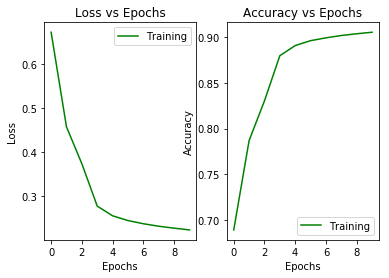

In [6]:
print(train_losses)
print(accuracies)

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, 'g', label='Training')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracies, 'g', label='Training')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#plt.subplot(1, 3, 3)
#plt.plot(times, range(epochs), 'g', label='Training')
#plt.title('Epochs vs Time')
#plt.xlabel('Time (s)')
#plt.ylabel('Epochs')
#plt.legend()

#plt.show()

### Test Network

In [7]:
PATH = './resnet33_radioml_brevitas_epoch_9.pth'
model1 = resnet33_quant(2)
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(6,32,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
#new_validations_sampler = torch.utils.data.SubsetRandomSampler(new_val_indices)
    
new_validation_loader = torch.utils.data.DataLoader(input_data, batch_size=1,shuffle=False, sampler=validation_sampler, num_workers=48, pin_memory=True)

print(len(validation_loader))

model1.eval()
for i,data in tqdm(enumerate(new_validation_loader)):
    signals, labels, snr = data
    signals, labels = signals.to(device), labels.to(device)
    #print(labels)
    signals_mean = torch.mean(signals, 1, keepdims=True)
    #print(signals.size())
    #print(signals_mean.size())
    signals = signals - signals_mean
    signals = torch.transpose(signals, 1, 2)

    #optimizer.zero_grad()
    outputs = model1.forward(signals)
    correct += torch.sum((torch.argmax(outputs,dim=1) == labels)).item()
    snr_value = snr.item()
    #print(snr_value)
    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(outputs,dim=1) == labels)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    #print(snr_accuracy)
    #print(torch.argmax(outputs,dim=1)==labels, correct)
    #loss = criterion(outputs,labels)
    #loss.backward()
    #optimizer.step()
    #predicted = torch.argmax(outputs, 1)#Calculate predicted value
    #print(predicted, labels)
    total += 1 #Increase by 1 batch
    #print(correct, total)
    #print(predicted == labels)
    #correct += torch.sum((predicted == labels)) #Increase if correct

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))
    

5325


255590it [2:34:03, 27.65it/s]

Accuracy of the network on the test images: 90.642044 %


In [8]:
for key,value in snr_accuracy.items():
    print('{:s} dB SNR: accuracy: {:f}'.format(key, value[0]/value[1]))

6 dB SNR: accuracy: 0.779142
8 dB SNR: accuracy: 0.841124
10 dB SNR: accuracy: 0.879905
12 dB SNR: accuracy: 0.898467
14 dB SNR: accuracy: 0.915759
16 dB SNR: accuracy: 0.925357
18 dB SNR: accuracy: 0.930473
20 dB SNR: accuracy: 0.935542
22 dB SNR: accuracy: 0.933611
24 dB SNR: accuracy: 0.934662
26 dB SNR: accuracy: 0.937058
28 dB SNR: accuracy: 0.934119
30 dB SNR: accuracy: 0.938361


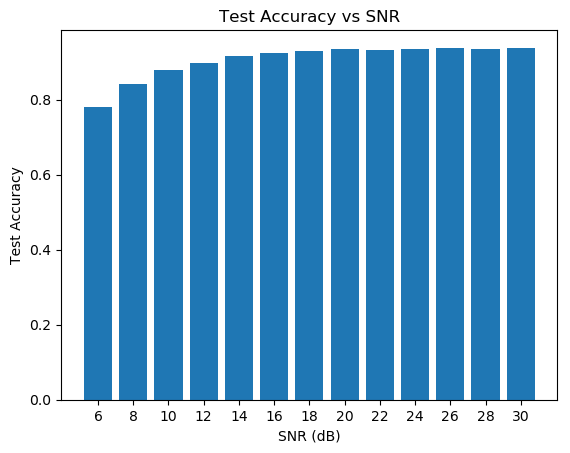

In [12]:
#db = range(6,31,2)
#snr_accuracy = [0.779142,0.841124,0.879905,0.898467,0.915759,0.925357,0.930473,0.935542,0.933611,0.934662,0.937058,0.934119,0.938361]

obj = db
pos = np.arange(len(objects))
perf = snr_accuracy

plt.bar(pos, perf, align='center', alpha=1)
plt.xticks(pos, obj)
plt.title('Test Accuracy vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Test Accuracy')

plt.show()